In [1]:
%matplotlib inline
from __future__ import division
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import struct
import pickle
import pandas as pd
import random

In [3]:
import sys
sys.path.append('../../src')

In [4]:
from pylab import rcParams
from IPython.display import clear_output
rcParams['figure.figsize'] = 16, 8
pd.options.display.max_columns = 999

In [5]:
from utils import FloatConvert32, FloatConvert64
from microssembly2 import Microssembly
from price_generator import random_walk, random_price
from simple_strategy import get_signal, loss_function, eval_individual, find_best_model, plot_trades, get_signal

In [6]:
def plot_signals(observed_signal, signal):
    df = pd.DataFrame({'true': observed_signal - 0.5, 'generated': signal - 0.5}, index=observed_signal.index)
    ax = df.plot.bar()
    my_xticks = ['Sell', 'Buy']
    ax.set_yticks([-1, 1])
    ax.set_yticklabels(my_xticks)
    ax.set_xticklabels([])

In [7]:
def get_strategy_signal(price, short_ma, long_ma, demo=False):
    long_ma = abs(int(long_ma))
    shares = 1

    try:
        ml = price.rolling(long_ma).mean()

        buy = (ml > price) & (ml.shift() < price.shift())  # ma cross up
        sell = (ml < price) & (ml.shift() > price.shift())  # ma cross down
        signal = pd.Series(index=price.index)
        signal[buy[buy != False].index] = shares
        signal[sell[sell != False].index] = 0
    except Exception as e:
        print('Long {} Short {}'.format(long_ma, short_ma))
        raise e

    if demo is True:
        ax = price.plot()
        ml.plot()
        plt.legend(['price', 'Long MA'], loc='best')
        ax.xaxis.grid(True, which='minor', linestyle='-', linewidth=0.25)

    return signal

def get_strategy_signal_1(price):
    return get_strategy_signal(price, 2, 8, False)

((128,), (31,), 2013-04-22    0.0
 2013-04-24    1.0
 2013-04-28    0.0
 2013-05-07    1.0
 2013-05-19    0.0
 dtype: float64)

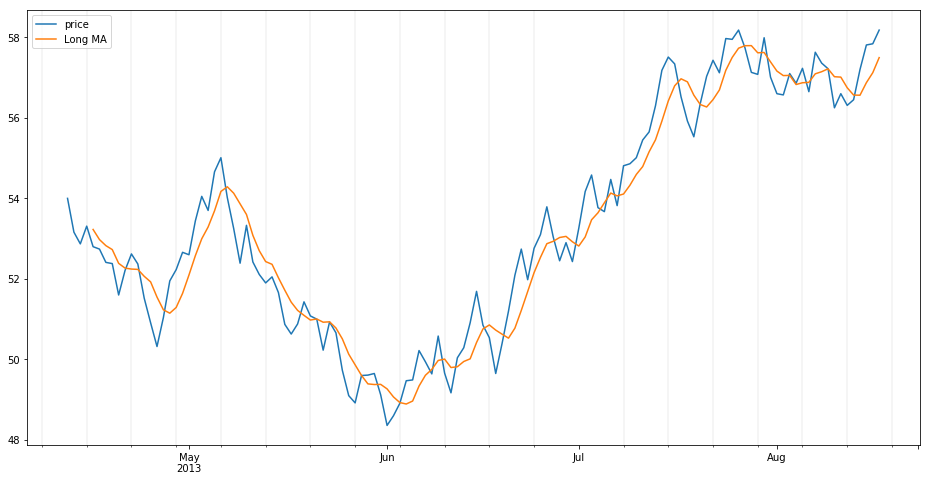

In [8]:
price = random_price()
signal = get_strategy_signal(price, 2, 5, True)
price.shape, signal.dropna().shape, signal.dropna()[:5]

In [9]:
mssembly = Microssembly(architecture = 4)
data = [1, 2, 3, 4]
mssembly.load_data(data)
mssembly.memory

array([1., 2., 3., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [10]:
moving_avg_prog = ([
    '110000001000',
    '001110001110',
    '110000011000',
    '001110001110',
    '110000101000',
    '001110001110',
    '110000111000',
    '001110001110',
    '101011000000',
    '101011000000',
    '101011000000',
    '101011000000',
    '010011101100',
    '110011001111' 
])
moving_avg_prog = ''.join(moving_avg_prog)

In [11]:
mssembly.run(moving_avg_prog, cycles=100)

['mov [0] [8]',
 'add [8] [14]',
 'mov [1] [8]',
 'add [8] [14]',
 'mov [2] [8]',
 'add [8] [14]',
 'mov [3] [8]',
 'add [8] [14]',
 'inc [12]',
 'inc [12]',
 'inc [12]',
 'inc [12]',
 'div [14] [12]',
 'mov [12] [15]']

In [12]:
assert mssembly.memory[15] == np.average(data), "Something went wrong!!!"

In [13]:
loss = []
for _ in range(1000):
    price = random_price()
    random_code = ''.join(list(map(str, np.random.randint(0, 2, size=1000))))
    signal = get_signal(price, random_code)
    observed_signal = get_strategy_signal_1(price)
    l = loss_function(signal, observed_signal)    
    if(l > 0):
        loss.append(l)
print(np.average(loss))

1.7416168823513068e-10


In [14]:
def get_strategy_signal_1(price):
    return get_strategy_signal(price, 2, 5, False)

pop, hof, _ = find_best_model(get_strategy_signal_1,
                              ngen=2000,
                              pop_size=1000,
                              mutpb=0.01,
                              indpb=0.01,
                              ind_size=100)

gen	nevals	avg        	std       	min        	max     
0  	1000  	0.000137405	0.00434294	1.42857e-10	0.137405
1  	1025  	0.225294   	0.0846108 	0.137405   	0.306748
2  	1027  	0.266655   	0.0805363 	0.106317   	0.480506
3  	1018  	0.289122   	0.0706342 	0.105677   	0.480506
4  	983   	0.301043   	0.0660595 	0.111441   	0.480506
5  	1008  	0.305388   	0.0651259 	0.085595   	0.480506
6  	1046  	0.305666   	0.0709657 	0.085595   	0.480506
7  	1004  	0.311973   	0.0709851 	0.0808328  	0.480506
8  	1059  	0.316012   	0.0743725 	0.108852   	0.480506
9  	987   	0.314835   	0.0764333 	0.103078   	0.480506
10 	1019  	0.324141   	0.0772262 	0.0909717  	0.480506
11 	1020  	0.321191   	0.0752861 	0.109059   	0.480506
12 	1054  	0.321167   	0.0817894 	0.105342   	0.480506
13 	1034  	0.322779   	0.0826201 	0.105342   	0.480506
14 	1051  	0.322028   	0.0860321 	0.110818   	0.480506
15 	1045  	0.328841   	0.0876982 	0.111111   	0.480506
16 	1023  	0.334762   	0.0856879 	0.110526   	0.480506
17 	1010  

148	1051  	0.413485   	0.133433  	0.0997506  	0.580402
149	991   	0.411698   	0.136719  	0.110831   	0.580402
150	985   	0.418085   	0.135295  	0.113837   	0.580402
151	1044  	0.418711   	0.139881  	0.0981194  	0.580402
152	1015  	0.433126   	0.137253  	0.0936281  	0.580402
153	997   	0.430962   	0.136573  	0.0936281  	0.580402
154	998   	0.44065    	0.129777  	0.102456   	0.580402
155	1009  	0.436445   	0.130968  	0.120926   	0.580402
156	1008  	0.428618   	0.134694  	0.0610056  	0.580402
157	981   	0.431345   	0.135037  	0.111239   	0.580402
158	1030  	0.426774   	0.136659  	0.0878906  	0.580402
159	1058  	0.4319     	0.134864  	0.108161   	0.580402
160	1020  	0.430509   	0.133686  	0.0964517  	0.580402
161	1027  	0.426576   	0.135344  	0.121313   	0.580402
162	1027  	0.42512    	0.134494  	0.109533   	0.580402
163	1030  	0.428428   	0.136082  	0.109533   	0.580402
164	1020  	0.428634   	0.136414  	0.0940893  	0.580402
165	1045  	0.422191   	0.136892  	0.0935013  	0.580402
166	1062  

297	987   	0.461187   	0.14428   	0.108553   	0.580402
298	1019  	0.455911   	0.148803  	0.114572   	0.580402
299	1010  	0.45975    	0.146834  	0.113018   	0.580402
300	1027  	0.458007   	0.149997  	0.1        	0.580402
301	1024  	0.457132   	0.149443  	0.0732558  	0.580402
302	1057  	0.451583   	0.14818   	0.104305   	0.580402
303	1038  	0.448189   	0.150582  	0.118519   	0.580402
304	1037  	0.453263   	0.149893  	0.115931   	0.580402
305	1017  	0.451998   	0.15162   	0.114434   	0.580402
306	968   	0.458084   	0.149719  	0.0995763  	0.580402
307	1039  	0.455701   	0.149158  	0.0995763  	0.580402
308	1020  	0.453449   	0.149964  	0.087308   	0.580402
309	1006  	0.456665   	0.146859  	0.105342   	0.580402
310	991   	0.460027   	0.145581  	0.105342   	0.580402
311	1031  	0.459365   	0.148441  	0.105342   	0.580402
312	949   	0.454068   	0.150571  	0.0979021  	0.580402
313	1001  	0.455338   	0.151266  	0.105641   	0.580402
314	1024  	0.455635   	0.152246  	0.11102    	0.580402
315	1049  

446	1000  	0.476338   	0.145662  	0.108992   	0.580402
447	1004  	0.469002   	0.152314  	0.0831281  	0.580402
448	1001  	0.468766   	0.150348  	0.110526   	0.580402
449	1043  	0.467345   	0.150875  	0.104185   	0.580402
450	1016  	0.469377   	0.147523  	0.0872948  	0.580402
451	1048  	0.464461   	0.149492  	0.104185   	0.580402
452	995   	0.461977   	0.14694   	0.104185   	0.580402
453	1011  	0.458559   	0.147733  	0.104185   	0.580402
454	1026  	0.455736   	0.14915   	0.104651   	0.580402
455	1027  	0.454069   	0.147957  	0.104651   	0.580402
456	1012  	0.463849   	0.148239  	0.104651   	0.580402
457	1026  	0.471293   	0.146827  	0.104046   	0.580402
458	1034  	0.462978   	0.148641  	0.120711   	0.580402
459	972   	0.46632    	0.14608   	0.0931034  	0.580402
460	1018  	0.46574    	0.147501  	0.11026    	0.580402
461	1028  	0.461899   	0.145234  	0.104738   	0.580402
462	1027  	0.459605   	0.150208  	0.0977354  	0.580402
463	1037  	0.450405   	0.153391  	0.111197   	0.580402
464	1009  

595	1017  	0.463749   	0.150183  	0.108381   	0.580402
596	972   	0.466127   	0.146977  	0.128342   	0.580402
597	1002  	0.466842   	0.153125  	0.0867725  	0.580402
598	1025  	0.462302   	0.152041  	0.0988479  	0.580402
599	968   	0.469573   	0.147454  	0.109717   	0.580402
600	1008  	0.470382   	0.147228  	0.112653   	0.580402
601	992   	0.476162   	0.146252  	0.12069    	0.580402
602	1008  	0.478022   	0.144477  	0.0975571  	0.580402
603	983   	0.473351   	0.148668  	0.112367   	0.580402
604	1057  	0.461454   	0.153348  	0.103866   	0.580402
605	1052  	0.4637     	0.148585  	0.119311   	0.580402
606	996   	0.457742   	0.151701  	0.103984   	0.580402
607	986   	0.46695    	0.147315  	0.109578   	0.580402
608	1006  	0.465141   	0.143488  	0.110328   	0.580402
609	992   	0.465799   	0.146579  	0.0996759  	0.580402
610	971   	0.458357   	0.147356  	0.113445   	0.580402
611	1032  	0.460285   	0.151243  	0.0863724  	0.580402
612	1073  	0.453577   	0.15278   	0.0908517  	0.580402
613	1005  

744	1002  	0.474296   	0.145183  	0.108871   	0.580402
745	998   	0.479526   	0.144264  	0.109014   	0.580402
746	1022  	0.468102   	0.149109  	0.109014   	0.580402
747	1008  	0.466629   	0.147953  	0.112054   	0.580402
748	1026  	0.45971    	0.15114   	0.113645   	0.580402
749	1067  	0.460597   	0.150778  	0.0961538  	0.580402
750	1021  	0.454105   	0.15234   	0.0962567  	0.580402
751	1058  	0.461316   	0.150364  	0.106431   	0.580402
752	972   	0.465254   	0.147657  	0.115566   	0.580402
753	1012  	0.462657   	0.147598  	0.106061   	0.580402
754	1022  	0.462908   	0.147614  	0.105      	0.580402
755	1046  	0.459125   	0.1495    	0.106431   	0.580402
756	1067  	0.451653   	0.151176  	0.104046   	0.580402
757	993   	0.459231   	0.148083  	0.102755   	0.580402
758	1035  	0.456704   	0.14969   	0.102957   	0.580402
759	1041  	0.458281   	0.149261  	0.102957   	0.580402
760	992   	0.462772   	0.147751  	0.105      	0.580402
761	1007  	0.475742   	0.142486  	0.105      	0.580402
762	1073  

893	990   	0.448396   	0.155483  	0.108152   	0.580402
894	1006  	0.453311   	0.152205  	0.0866426  	0.580402
895	993   	0.460854   	0.14854   	0.11156    	0.580402
896	1003  	0.457025   	0.152492  	0.108976   	0.580402
897	1000  	0.458798   	0.150565  	0.0924045  	0.580402
898	1031  	0.459961   	0.1503    	0.11509    	0.580402
899	1011  	0.464225   	0.149568  	0.0977354  	0.580402
900	1008  	0.469621   	0.14711   	0.108243   	0.580402
901	1024  	0.464049   	0.148919  	0.0849448  	0.580402
902	1026  	0.471523   	0.144944  	0.0849448  	0.580402
903	1013  	0.472649   	0.146903  	0.0849448  	0.580402
904	1013  	0.468141   	0.148908  	0.113828   	0.580402
905	1043  	0.474539   	0.147301  	0.0995025  	0.580402
906	1014  	0.477551   	0.14726   	0.115385   	0.580402
907	1003  	0.471513   	0.146024  	0.115188   	0.580402
908	993   	0.471808   	0.150607  	0.0902098  	0.580402
909	1009  	0.470695   	0.148637  	0.105472   	0.580402
910	1021  	0.459994   	0.15095   	0.102632   	0.580402
911	1022  

1042	1043  	0.450105   	0.15213   	0.116643   	0.580402
1043	1041  	0.441745   	0.151648  	0.108739   	0.580402
1044	969   	0.440243   	0.15162   	0.0990917  	0.580402
1045	997   	0.446739   	0.150223  	0.11363    	0.580402
1046	1007  	0.452856   	0.147015  	0.108739   	0.580402
1047	1008  	0.451188   	0.152501  	0.108739   	0.580402
1048	1014  	0.454149   	0.152306  	0.0975571  	0.580402
1049	1016  	0.454409   	0.150382  	0.109698   	0.580402
1050	1020  	0.468385   	0.144075  	0.10412    	0.580402
1051	1016  	0.469206   	0.143603  	0.099723   	0.580402
1052	1005  	0.454059   	0.151066  	0.0977354  	0.580402
1053	1056  	0.455099   	0.150843  	0.0977354  	0.580402
1054	1025  	0.456317   	0.152325  	0.105829   	0.580402
1055	1058  	0.454933   	0.151854  	0.115179   	0.580402
1056	1036  	0.452292   	0.152849  	0.108761   	0.580402
1057	1019  	0.450257   	0.150559  	0.105829   	0.580402
1058	1010  	0.456951   	0.147121  	0.0954762  	0.580402
1059	1008  	0.456958   	0.147138  	0.11215    	0

1189	1027  	0.4564     	0.149241  	0.0968564  	0.580402
1190	1008  	0.458472   	0.148695  	0.102827   	0.580402
1191	1019  	0.462913   	0.147681  	0.102827   	0.580402
1192	1010  	0.464045   	0.146093  	0.111015   	0.580402
1193	1039  	0.457715   	0.147162  	0.103125   	0.580402
1194	1029  	0.464024   	0.146955  	0.100163   	0.580402
1195	1024  	0.464098   	0.149511  	0.116934   	0.580402
1196	1014  	0.466238   	0.149835  	0.120112   	0.580402
1197	992   	0.465031   	0.150826  	0.10146    	0.580402
1198	1028  	0.459592   	0.15289   	0.111201   	0.580402
1199	1003  	0.463539   	0.150691  	0.111201   	0.580402
1200	1060  	0.457761   	0.153337  	0.10146    	0.580402
1201	967   	0.470532   	0.148064  	0.108919   	0.580402
1202	1005  	0.476207   	0.145711  	0.111432   	0.580402
1203	1030  	0.473104   	0.147134  	0.112243   	0.580402
1204	1004  	0.473466   	0.14702   	0.0851528  	0.580402
1205	1019  	0.468465   	0.150944  	0.0851528  	0.580402
1206	1047  	0.470979   	0.151145  	0.113208   	0

1336	1054  	0.461218   	0.14956   	0.115629   	0.580402
1337	1068  	0.457799   	0.149063  	0.108935   	0.580402
1338	980   	0.455587   	0.1504    	0.110612   	0.580402
1339	967   	0.457574   	0.15018   	0.0764665  	0.580402
1340	1016  	0.461962   	0.147334  	0.10571    	0.580402
1341	996   	0.461454   	0.148424  	0.110429   	0.580402
1342	1035  	0.452322   	0.151982  	0.103654   	0.580402
1343	1034  	0.452979   	0.153154  	0.107399   	0.580402
1344	1078  	0.446931   	0.155708  	0.104539   	0.580402
1345	1026  	0.449471   	0.151997  	0.106471   	0.580402
1346	1036  	0.45088    	0.152637  	0.0936139  	0.580402
1347	1006  	0.443975   	0.153587  	0.102308   	0.580402
1348	1004  	0.447366   	0.152414  	0.103623   	0.580402
1349	983   	0.448204   	0.150895  	0.098977   	0.580402
1350	1003  	0.458293   	0.146297  	0.10412    	0.580402
1351	1002  	0.451253   	0.149983  	0.109185   	0.580402
1352	1020  	0.448272   	0.150421  	0.0982143  	0.580402
1353	1018  	0.441326   	0.151043  	0.0982143  	0

1483	1009  	0.444605   	0.151799  	0.108718   	0.580402
1484	1009  	0.450116   	0.150438  	0.10949    	0.580402
1485	1004  	0.451196   	0.151841  	0.109237   	0.580402
1486	987   	0.452117   	0.150871  	0.11661    	0.580402
1487	1047  	0.452231   	0.154175  	0.114583   	0.580402
1488	1047  	0.45033    	0.150451  	0.111201   	0.580402
1489	1044  	0.45868    	0.145007  	0.113616   	0.580402
1490	1014  	0.459939   	0.144567  	0.0839161  	0.580402
1491	1049  	0.462709   	0.14879   	0.104396   	0.580402
1492	1008  	0.46372    	0.150659  	0.108739   	0.580402
1493	1050  	0.457677   	0.151948  	0.107027   	0.580402
1494	1063  	0.45603    	0.152031  	0.104185   	0.580402
1495	1057  	0.456726   	0.149212  	0.104185   	0.580402
1496	1055  	0.459234   	0.149435  	0.104185   	0.580402
1497	1004  	0.464334   	0.149466  	0.087766   	0.580402
1498	1018  	0.463814   	0.150315  	0.098445   	0.580402
1499	1011  	0.468641   	0.150304  	0.087766   	0.580402
1500	1031  	0.458007   	0.150321  	0.10031    	0

1630	1019  	0.45609    	0.150529  	0.100382   	0.580402
1631	1046  	0.466346   	0.149908  	0.105018   	0.580402
1632	996   	0.467514   	0.14929   	0.114545   	0.580402
1633	1035  	0.467068   	0.150111  	0.109384   	0.580402
1634	988   	0.465762   	0.150471  	0.109384   	0.580402
1635	1015  	0.469332   	0.149136  	0.116146   	0.580402
1636	1047  	0.468347   	0.147633  	0.108066   	0.580402
1637	1010  	0.45413    	0.151939  	0.107224   	0.580402
1638	1038  	0.461124   	0.14758   	0.112792   	0.580402
1639	1028  	0.45094    	0.151712  	0.114953   	0.580402
1640	1042  	0.44769    	0.152645  	0.114953   	0.580402
1641	1005  	0.455539   	0.147918  	0.107224   	0.580402
1642	1017  	0.456659   	0.151214  	0.105018   	0.580402
1643	1009  	0.457738   	0.152936  	0.109756   	0.580402
1644	1008  	0.451513   	0.153491  	0.103448   	0.580402
1645	960   	0.451428   	0.150098  	0.110656   	0.580402
1646	1015  	0.449157   	0.152679  	0.106195   	0.580402
1647	1007  	0.454913   	0.146585  	0.121113   	0

1777	1076  	0.463329   	0.148739  	0.0919149  	0.580402
1778	1049  	0.460629   	0.151322  	0.112785   	0.580402
1779	1030  	0.461567   	0.14903   	0.105183   	0.580402
1780	1001  	0.468987   	0.148892  	0.096404   	0.580402
1781	1030  	0.468586   	0.147765  	0.105183   	0.580402
1782	991   	0.464806   	0.149873  	0.105183   	0.580402
1783	1019  	0.459547   	0.150437  	0.119947   	0.580402
1784	1007  	0.457742   	0.151933  	0.104272   	0.580402
1785	1051  	0.46275    	0.149124  	0.065475   	0.580402
1786	1056  	0.46217    	0.151022  	0.100855   	0.580402
1787	1068  	0.457291   	0.151898  	0.096404   	0.580402
1788	1004  	0.450972   	0.152117  	0.106689   	0.580402
1789	1042  	0.447501   	0.152685  	0.103377   	0.580402
1790	1022  	0.440977   	0.15436   	0.0992647  	0.580402
1791	1031  	0.441236   	0.150255  	0.109384   	0.580402
1792	1012  	0.447218   	0.151733  	0.104776   	0.580402
1793	991   	0.455889   	0.147314  	0.114739   	0.580402
1794	1067  	0.455451   	0.148971  	0.103377   	0

1924	1063  	0.458465   	0.148995  	0.105248   	0.580402
1925	1047  	0.460329   	0.148366  	0.108155   	0.580402
1926	987   	0.465635   	0.147987  	0.103913   	0.580402
1927	1040  	0.460405   	0.151647  	0.094513   	0.580402
1928	1029  	0.4575     	0.150299  	0.11363    	0.580402
1929	1025  	0.457658   	0.149951  	0.114312   	0.580402
1930	1009  	0.462025   	0.149616  	0.106507   	0.580402
1931	1031  	0.464397   	0.148071  	0.114723   	0.580402
1932	1024  	0.46542    	0.148577  	0.103913   	0.580402
1933	1029  	0.461247   	0.147337  	0.114723   	0.580402
1934	1019  	0.458883   	0.149058  	0.094513   	0.580402
1935	1056  	0.451875   	0.153488  	0.104482   	0.580402
1936	1009  	0.457563   	0.148522  	0.0935013  	0.580402
1937	1034  	0.454739   	0.151137  	0.109956   	0.580402
1938	977   	0.466493   	0.146069  	0.109384   	0.580402
1939	1039  	0.467166   	0.146384  	0.094513   	0.580402
1940	1025  	0.463457   	0.15113   	0.0998415  	0.580402
1941	999   	0.470665   	0.150053  	0.0998415  	0

In [15]:
best_code = ''.join(map(str, hof[0]))

In [16]:
all_loss = []
for i in range(100):
    price = random_price()
    signal = get_signal(price, best_code)
    observed_signal = get_strategy_signal_1(price)
    all_loss.append(loss_function(signal, observed_signal))
np.average(all_loss)

0.24978710334808915

In [17]:
signal.dropna()[:10]

2005-07-13    0.0
2005-07-15    0.0
2005-07-17    0.0
2005-07-19    0.0
2005-07-21    0.0
2005-07-23    0.0
2005-07-25    0.0
2005-07-27    1.0
2005-07-29    0.0
2005-07-31    1.0
dtype: float64

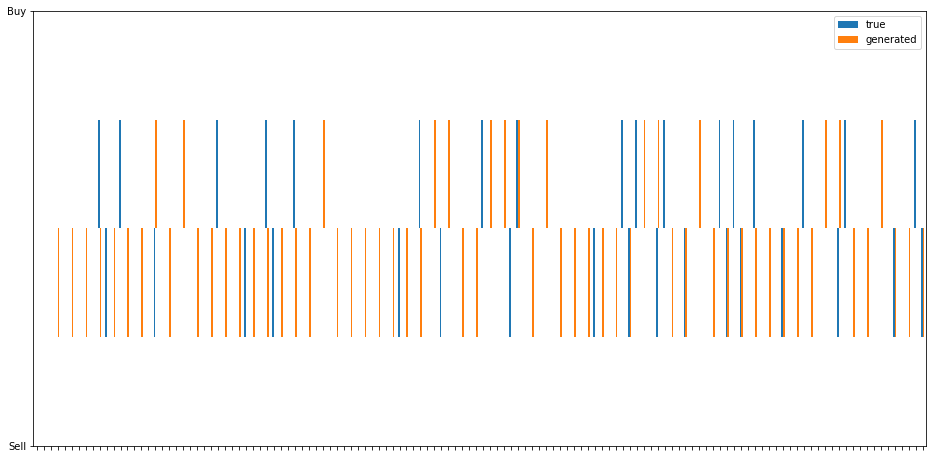

In [18]:
plot_signals(observed_signal, signal)

In [19]:
import microssembly
mssembly = Microssembly(architecture=4)
mssembly.run(best_code)

['bin-max [0] [15]',
 'div [8] [14]',
 'bin-min [3] [12]',
 'max [13] [14]',
 'bin-min [7] [8]',
 'dec [1]']

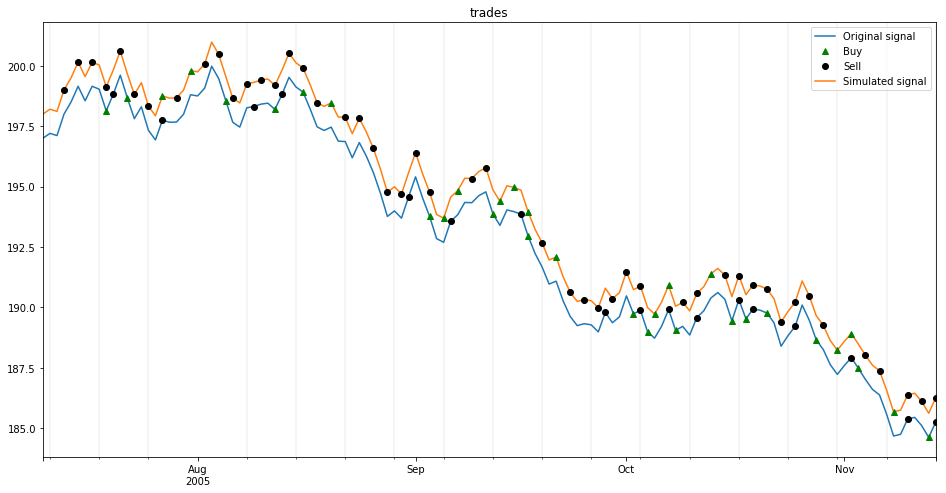

In [20]:
plot_trades(price, observed_signal, plt)
plot_trades(price + 1, signal, plt)
plt.legend(['Original signal', 'Buy', 'Sell', 'Simulated signal'], loc='best')

In [21]:
a = (np.sum(signal[observed_signal[observed_signal == 1].index] == 1)
     / len(observed_signal[observed_signal == 1]) + 1e-9)
b = (np.sum(signal[observed_signal[observed_signal == 0].index] == 0)
     / len(observed_signal[observed_signal == 0]) + 1e-9)
c = (np.sum(np.isnan(signal[observed_signal[observed_signal.isna()].index]))
     / len(observed_signal[observed_signal.isna()]) + 1e-9)

In [22]:
a, b, c, 3 / (1/a + 1/b + 1/c)

(0.058823530411764705, 0.41176470688235295, 0.500000001, 0.14000000195280002)